In [92]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import boto3
import warnings
import matplotlib.pyplot as plt
from collections import OrderedDict
warnings.filterwarnings('ignore')
%matplotlib inline

In [93]:
# Read the expected csv (the original data)
s3 = boto3.resource('s3')

# bucket = 'dev-matching-steps'
# read_prefix = 'bow/beer/binary'
# read_prefix_dataset = 'bow/beer'
# prefix = 'bow/beer/binary'

# s3.Bucket(bucket).download_file(read_prefix_dataset + '/' + raw_data_filename, 'raw_data.csv')

In [94]:
def load_data(csv_name):
    data = pd.read_csv(csv_name, error_bad_lines=False)
    return data

def add_prefix(df, suffix):
    for col in df:
        if (col.endswith('_id')) & (col != 'bar_product_id'):
            df.rename(columns={col: col+suffix}, inplace=True)
    return df

def merge_dfs(y_test, y_pred, products_revenue):
    test_pred_df = y_test.merge(y_pred, on='bar_product_id')
    main_df = test_pred_df.merge(products_revenue, on='bar_product_id')
    print("y_test: ", y_test.shape)
    print("y_pred: ", y_pred.shape)
    print("products_revenue: ", products_revenue.shape)
    print("main_df: ", main_df.shape)
    return main_df

In [112]:
def check_model_quality(col):

    report_df = main_df
    threshold_range = np.arange(0.5, 1, .01)
    threshold_list = []
    accuracy_list = []
    matching_size_list = []
    revenue_size_list = []
    total_obs = report_df.shape[0]
    total_revenue = report_df.revenue.sum()
    output_dict = {}

    for t in threshold_range:
        threshold = t
        if col == 'all':
            above_threshold_df = report_df[(report_df['brand_id' + '_prob'] > threshold) &\
                             (report_df['volume_id' + '_prob'] > threshold) &\
                             (report_df['serving_type_id' + '_prob'] > threshold)]
            above_threshold_df['accuracy'] = np.where((above_threshold_df['brand_id_test'] == above_threshold_df['brand_id_pred']) &\
                                                   (above_threshold_df['volume_id_test'] == above_threshold_df['volume_id_pred'])&\
                                                   (above_threshold_df['serving_type_id_test'] == above_threshold_df['serving_type_id_pred']), 1, 0)
            fully_predicted = float(above_threshold_df[above_threshold_df['accuracy'] == 1].shape[0])
            accuracy = fully_predicted/total_obs
        else:
            above_threshold_df = report_df[(report_df[col + '_prob'] > threshold)]
            y_test = above_threshold_df[[col + '_test']]
            y_pred = above_threshold_df[[col + '_pred']]
            if col == 'volume_id':
                y_test[col + '_test'] = y_test[col + '_test'].apply(str)
                y_pred[col + '_pred'] = y_pred[col + '_pred'].apply(str)

            accuracy = accuracy_score(y_test, y_pred)

        above_threshold_count = float(above_threshold_df.shape[0])
        above_threshold_revenue = float(above_threshold_df.revenue.sum())
        matching_size = above_threshold_count/total_obs
        revenue_size = above_threshold_revenue/total_revenue

        threshold_list.append(threshold)
        accuracy_list.append(accuracy)
        matching_size_list.append(matching_size)
        revenue_size_list.append(revenue_size)
        
        key = threshold
        value = {'accuracy':accuracy, 'matching_size': matching_size, 'revenue_size':revenue_size}   
        output_dict[threshold] = value
 
    results = create_resultes_df(threshold_list, accuracy_list, matching_size_list, revenue_size_list)
    results_with_prefix = add_prefix_to_final_results(results, col)
    
    return output_dict, threshold_list, accuracy_list, matching_size_list, revenue_size_list, results_with_prefix

def plot_against_threshold(threshold_list, matching_size_list, accuracy_list, revenue_size_list):
    plt.plot(threshold_list, matching_size_list, color='blue', label='matching_size')
    plt.plot(threshold_list, accuracy_list, color='purple', label='accuracy')
    plt.plot(threshold_list, revenue_size_list, color='green', label='revenue_size')
    plt.legend()
    plt.xlabel('threshold')
    plt.show()

def plot_against_revenue(x, y1, y2):
    plt.plot(x, y1, color='blue', label='accuracy')
    plt.plot(x, y2, color='green', label='threshold')
    plt.legend()
    plt.xlabel('revenue_size')
    plt.show()
    
    
def print_results(res_dict):
    for k, v in sorted(res_dict.items()):
        print k, '->', v
        print 
    
def create_resultes_df(threshold, accuracy, matching, revenue):
    df = pd.DataFrame({'threshold' : threshold,
                     'accuracy': accuracy,
                     'matching_size': matching,
                     'revenue_size': revenue})
    return df


def add_prefix_to_final_results(df, col_checked):
    for df_col in df:
        if (df_col != 'threshold'):
            df.rename(columns={df_col: col_checked + '_' + df_col}, inplace=True)
    return df
    

In [107]:
model_name_results_file_name = 'ensemble_results.csv'
model_name = 'ensemble'

In [108]:
y_test_orig = load_data('input_beer.csv')
y_test = add_prefix(y_test_orig, '_test')

y_pred_orig = load_data(model_name_results_file_name)
y_pred = add_prefix(y_pred_orig, '_pred')

products_revenue = load_data('products_revenue.csv')

In [109]:
# Check 
print('y_test: ', y_test.columns)
print('y_pred: ', y_pred.columns)

('y_test: ', Index([u'bar_product_id', u'brand_id_test', u'title', u'price',
       u'category_id_test', u'country_id_test', u'pos_category_name',
       u'super_brand_id_test', u'volume_id_test', u'beer_type_id_test',
       u'serving_type_id_test', u'unique_id_test', u'train'],
      dtype='object'))
('y_pred: ', Index([u'brand_id_pred', u'super_brand_id_pred', u'serving_type_id_pred',
       u'volume_id_pred', u'bar_product_id', u'brand_id_prob',
       u'super_brand_id_prob', u'serving_type_id_prob', u'volume_id_prob'],
      dtype='object'))


In [110]:
main_df = merge_dfs(y_test, y_pred, products_revenue)

('y_test: ', (72660, 13))
('y_pred: ', (20000, 9))
('products_revenue: ', (70251, 2))
('main_df: ', (19329, 22))


model_name:  ensemble
parameter: brand_id


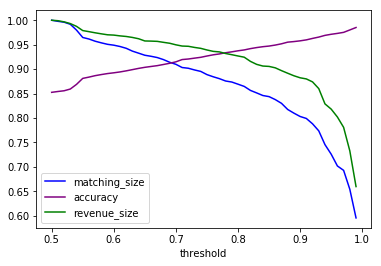

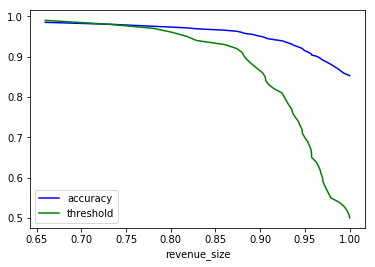

parameter: volume_id


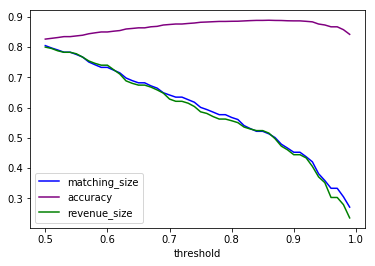

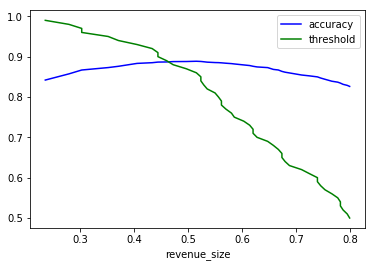

parameter: serving_type_id


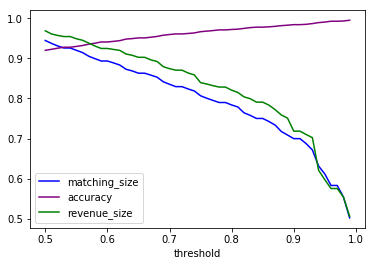

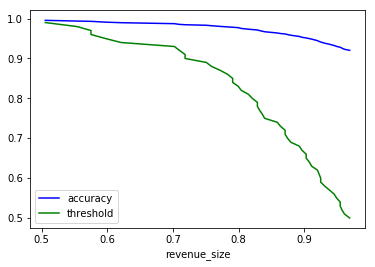

parameter: all


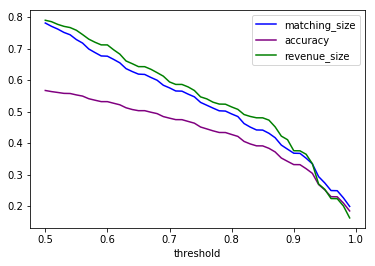

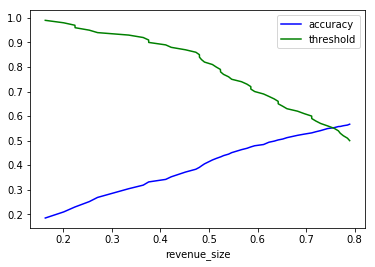

In [113]:
cols_ls = ['brand_id', 'volume_id', 'serving_type_id', 'all']
dfs=[]

print 'model_name: ',model_name
for one_col in cols_ls:
    print 'parameter:',one_col
    output_dict, threshold_list, accuracy_list, matching_size_list, revenue_size_list, df = check_model_quality(one_col)
    plot_against_threshold(threshold_list, matching_size_list, accuracy_list, revenue_size_list)
    plot_against_revenue(revenue_size_list, accuracy_list, threshold_list)
    dfs.append(df)
    
df_final = reduce(lambda left,right: pd.merge(left,right,on='threshold'), dfs)
final_sorted = df_final.sort_values('all_revenue_size', ascending=False)
final = final_sorted[[
                    'all_revenue_size',
                    'all_accuracy',
                    'brand_id_accuracy',
                    'volume_id_accuracy',    
                    'serving_type_id_accuracy',    
                    'all_matching_size',
                    'brand_id_matching_size',
                    'volume_id_matching_size',
                    'serving_type_id_matching_size',
                    'brand_id_revenue_size',
                    'volume_id_revenue_size',
                    'serving_type_id_revenue_size',
                    'threshold']]

output_file_name = model_name + '_final_results.csv'
final.to_csv(output_file_name)
